In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib
import pandas as pd
import numpy as np
import os

ppl_per_agent = 100

path_gem_names = os.getcwd() + '/Data/Gem_alfabetisch_2018.csv'

DF_Gem = pd.read_csv(path_gem_names, delimiter=';', encoding='latin-1')
UniLocs = np.unique(DF_Gem.Gemeentenaam)
UniIDs = [list(DF_Gem.GemeentecodeGM[DF_Gem.Gemeentenaam == i])[0] for i in UniLocs]

path_demo = os.getcwd() + '/Data/DemographicMatrix.csv'

DF_Demo = pd.read_csv(path_demo, delimiter=',')
DemoIDs = np.array(DF_Demo['Unnamed: 0'])
DemoMat_unsorted = np.array(DF_Demo[DF_Demo.keys()[1:]])
DemoMat_sorted = []
for ID in UniIDs:
    DemoMat_sorted.append(DemoMat_unsorted[DemoIDs == int(ID.lstrip('GM'))])
DemoMat = (np.array(DemoMat_sorted)/ppl_per_agent).astype(int)[:, 0]

DemoFractionsMat = np.zeros(shape=DemoMat.shape)
for i in range(0, DemoMat.shape[0]):
    DemoFractionsMat[i] = DemoMat[i] / np.sum(DemoMat[i])



# Useful functions
def create_spatial_plot(data_per_municipality, title, legend_label, min_val=None, max_val=None):
    '''
    Plot map with data per municipality
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    if min_val==None:
        min_val = np.min(data_per_municipality)
    if max_val==None:
        max_val = np.max(data_per_municipality)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.suptitle(title)
    ax.axis('off')

    mapdf.insert(0, 'DATA', data_per_municipality)

    mapdf.plot(ax=ax, column="DATA", vmin=min_val, vmax=max_val,
               legend=True, legend_kwds={"label": legend_label, "orientation": "vertical"})

    plt.plot()

def create_spatial_plot_log(data_per_municipality, title, legend_label, min_val=None, max_val=None):
    '''
    Plot map with data per municipality
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    if min_val==None:
        min_val = np.min(data_per_municipality)
    if max_val==None:
        max_val = np.max(data_per_municipality)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.suptitle(title)
    ax.axis('off')

    mapdf.insert(0, 'DATA', data_per_municipality)

    mapdf.plot(ax=ax, column="DATA", 
               legend=True, legend_kwds={"label": legend_label, "orientation": "vertical"}, norm=matplotlib.colors.LogNorm(min_val, max_val))

    plt.plot()



def create_spatial_4plots(data_per_municipality, title, legend_label):
    '''
    Plot 4 maps, evenly spread out over time
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    max_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 4, figsize=(20, 8))
    fig.suptitle(title)

    mapdf.insert(0, 'DATA_QUARTER', data_per_municipality[int(max_time/4)])
    mapdf.insert(0, 'DATA_HALF', data_per_municipality[int(max_time/2)])
    mapdf.insert(0, 'DATA_3QUARTER', data_per_municipality[int(max_time*3/4)])
    mapdf.insert(0, 'DATA_MAXTIME', data_per_municipality[max_time-1])

    mapdf.plot(ax=axs[0], column="DATA_QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[1], column="DATA_HALF", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[2], column="DATA_3QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[3], column="DATA_MAXTIME", norm=matplotlib.colors.LogNorm(1,max_val))


    axs[0].set_title('t=' + str(int(max_time/4)))
    axs[1].set_title('t=' + str(int(max_time/2)))
    axs[2].set_title('t=' + str(int(max_time*3/4)))
    axs[3].set_title('t=' + str(int(max_time-1)))

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[3].axis('off')

    mappable = cm.ScalarMappable(
        norm=mcolors.Normalize(1, max_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


# DAILY PLOT FOR 1 WEEK

def create_spatial_7plots(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot a daily map for 1 week
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = day + 1
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


def create_spatial_7plots3(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()

def create_spatial_7plots3_linear(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])
    min_legend_val = np.min(data_per_municipality[max_time-1])

    print(max_legend_val)
    print(min_legend_val)

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), legend=True)
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    plt.tight_layout()
    plt.plot()


def combine_runs_avg(all_run_data, padding=0.000001):
    merged_data = np.zeros(shape= all_run_data[0].shape)
    for i in range (0, len(all_run_data)):
        merged_data = merged_data + all_run_data[i]
    merged_data = (merged_data / len(all_run_data)) + padding
    return merged_data

def combine_demos_weighted(municipality_id, demo_run_data, padding=0.000001):
    fracs = DemoFractionsMat[municipality_id]
    merged_data = np.zeros(shape= demo_run_data[0].shape)
    for i in range (0, len(demo_run_data)):
        weighted = fracs[i] * demo_run_data[i]
        merged_data = merged_data + weighted
    merged_data = merged_data + padding
    return merged_data


In [3]:
import pandas as pd
import numpy as np
import os

def load_total_infected_per_municipality(path_data, loc, group, run):
    # Load general model data
    peopleDF = pd.read_pickle(path_data + 'PeopleDF.pkl')
    extraPeopleDF = pd.read_pickle(path_data + 'ExtraPeopleDF.pkl')
    status = np.load(path_data + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Status_' + str(run) + '.npz')
    uniLocs = np.array(pd.read_pickle(os.path.normpath(path_data + '../../../Gemeenten.pkl'))).T[0]
    loc_to_id = {val: i for i, val in enumerate(uniLocs)}
    uniGroups = np.unique(np.array(extraPeopleDF.Group))

    extra_agents = extraPeopleDF.loc[(extraPeopleDF['Home'] == uniLocs[loc]) & (extraPeopleDF['Group'] == uniGroups[group])]
    peopleDF = pd.concat([peopleDF, extra_agents], ignore_index=True)

    # Load model output data
    timesteps = status['indptr'].shape[0] - 1
    data = status['data']
    indptr = status['indptr']
    indices = status['indices']

    # Compute for every timestep how many infected people there are in every municipality
    infected_per_municipality = np.zeros((timesteps, 380))
    for t in range(0, timesteps):
        data_t = data[indptr[t] : indptr[t + 1]]
        agents_status_t = indices[indptr[t] : indptr[t + 1]]

        infected_agents = agents_status_t[(data_t == 2) | (data_t == 3)]
        infected_agents_homes = np.array(peopleDF.loc[infected_agents]['Home'])
        for home in infected_agents_homes:
            infected_per_municipality[t, loc_to_id[home]] += 1

    return infected_per_municipality

def load_total_infected_avg_runs(path_data, loc, group, seeds, runs_per_seed):
    all_data = []
    for seed in range(seeds):
        path = path_data + f'Seed_{seed}/'
        for run in range(runs_per_seed):
            all_data.append(load_total_infected_per_municipality(path, loc, group, run))
            # print("Loaded & computed loc: " +str(loc) + " group: " + str(group) + " run: " + str(run)) 

    # Average the data
    n_data = seeds * runs_per_seed
    merged_data = np.zeros(all_data[0].shape)
    for i in range(n_data):
        merged_data = merged_data + all_data[i]
    merged_data = merged_data / n_data
    return merged_data

0	's-Gravenhage:  106.24000000000001
1	's-Hertogenbosch:  97.12
2	Aa en Hunze:  91.28
3	Aalburg:  122.99999999999999
4	Aalsmeer:  129.88
5	Aalten:  80.48
6	Achtkarspelen:  79.88000000000001
7	Alblasserdam:  113.35999999999999
8	Albrandswaard:  115.03999999999999
9	Alkmaar:  129.92000000000002
10	Almelo:  90.16000000000001
11	Almere:  117.88000000000001
12	Alphen aan den Rijn:  130.24
13	Alphen-Chaam:  127.03999999999999
14	Ameland:  79.80000000000001
15	Amersfoort:  123.60000000000001
16	Amstelveen:  121.35999999999999
17	Amsterdam:  107.36
18	Apeldoorn:  96.56
19	Appingedam:  66.92
20	Arnhem:  96.68
21	Assen:  74.80000000000001
22	Asten:  107.24
23	Baarle-Nassau:  126.56
24	Baarn:  123.60000000000001
25	Barendrecht:  102.88
26	Barneveld:  106.52
27	Bedum:  112.68
28	Beek:  89.12
29	Beemster:  127.44
30	Beesel:  89.36
31	Berg en Dal:  90.04
32	Bergeijk:  114.72000000000001
33	Bergen (L.):  100.60000000000002
34	Bergen (NH.):  104.32
35	Bergen op Zoom:  100.08000000000001
36	Berkelland:

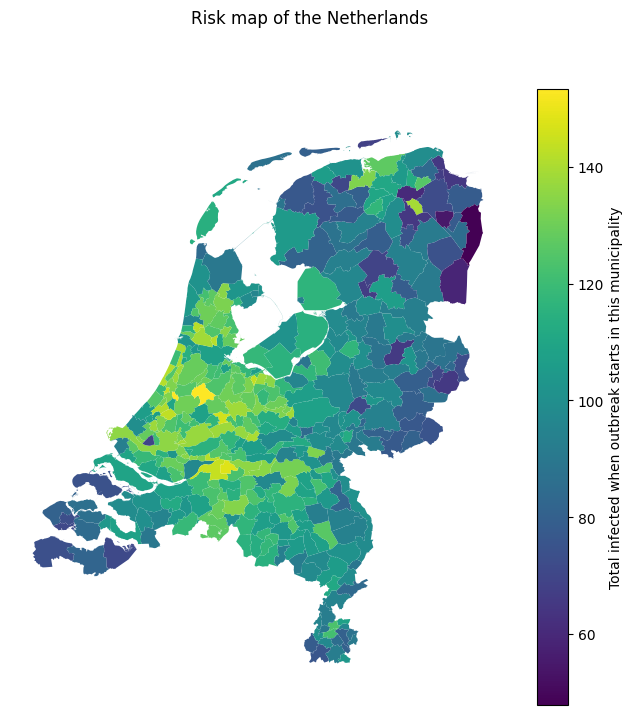

In [14]:
path = os.getcwd() + '/cluster/results/3/High/'

loc_name = np.array(pd.read_pickle(os.path.normpath(path + '../../Gemeenten.pkl'))).T[0]
n_mun = len(loc_name)
t_max = 21 * 24

risk_map = np.zeros(n_mun)
infected_per_municipality = np.zeros((n_mun, t_max, n_mun))
for loc in range(n_mun):
    infected_per_municipality[loc] = load_total_infected_avg_runs(path, loc, 3, 5, 5)
    risk_map[loc] = np.sum(infected_per_municipality[loc, t_max - 1])
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk_map[loc]))

# Store the infected data per municipality, because it takes a while to generate
np.save(path + 'Infected_Per_Municipality_New', infected_per_municipality)

create_spatial_plot(risk_map, 'Risk map of the Netherlands', 'Total infected when outbreak starts in this municipality')



0	's-Gravenhage:  3926.273283237867
1	's-Hertogenbosch:  3682.2121233384178
2	Aa en Hunze:  3224.049401993949
3	Aalburg:  4623.581785003808
4	Aalsmeer:  4809.551878006162
5	Aalten:  2907.46707772903
6	Achtkarspelen:  2832.281473870033
7	Alblasserdam:  4266.770734098299
8	Albrandswaard:  4268.811947652375
9	Alkmaar:  4799.408597985786
10	Almelo:  3211.973524730239
11	Almere:  4356.24121976829
12	Alphen aan den Rijn:  4917.9116191879075
13	Alphen-Chaam:  4625.092217432839
14	Ameland:  2772.8892274961945
15	Amersfoort:  4754.292425648309
16	Amstelveen:  4586.784228038193
17	Amsterdam:  3943.64836233131
18	Apeldoorn:  3484.639398435196
19	Appingedam:  2364.0205697639476
20	Arnhem:  3461.473404324028
21	Assen:  2669.0364739546544
22	Asten:  3974.3833397433245
23	Baarle-Nassau:  4686.422745945678
24	Baarn:  4661.332231314127
25	Barendrecht:  3921.693221918731
26	Barneveld:  3987.4610747979245
27	Bedum:  4150.046875765354
28	Beek:  3148.2587119934715
29	Beemster:  4786.416711199568
30	Beesel:

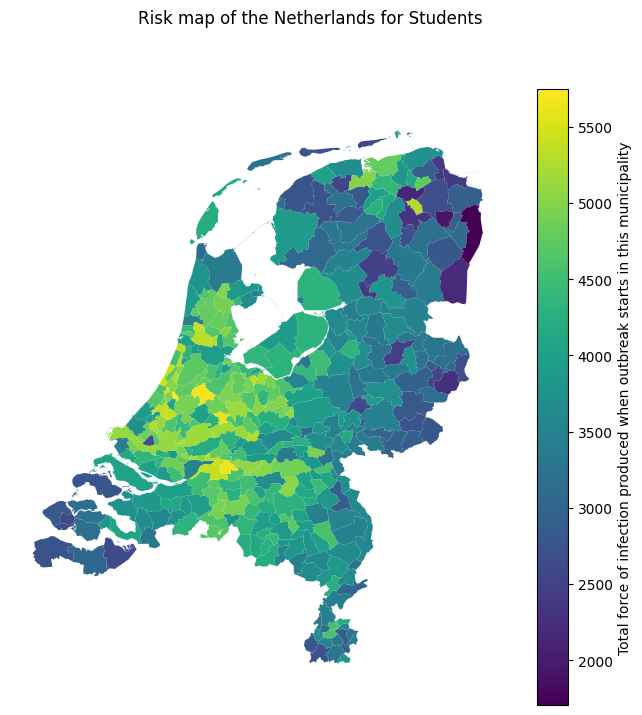

In [6]:
def load_foi_avg_runs(path_data, loc, group, seeds, runs):
    all_data = []
    for seed in range(seeds):
        path = path_data + f'Seed_{seed}/'
        for run in range(runs):
            foi_data = np.load(path + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Infection_Pressure_' + str(run) + '.npy')
            all_data.append(foi_data)

    # Average the data
    n_data = seeds * runs
    merged_data = np.zeros(all_data[0].shape)
    for i in range(n_data):
        merged_data = merged_data + all_data[i]
    merged_data = merged_data / n_data
    return merged_data

path = os.getcwd() + '/cluster/results/3/High/'

loc_name = np.array(pd.read_pickle(os.path.normpath(path + '../../Gemeenten.pkl'))).T[0]

risk_map = np.zeros(380)
for loc in range(380):
    infected_per_municipality = load_foi_avg_runs(path, loc, 3, 5, 5)
    t_max = infected_per_municipality.shape[0]
    risk = np.sum(infected_per_municipality[t_max - 1])
    risk_map[loc] = risk
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk))

create_spatial_plot(risk_map, 'Risk map of the Netherlands for Students', 'Total force of infection produced when outbreak starts in this municipality')

220	Nieuwkoop: 153.32
184	Leiderdorp: 152.92000000000002
363	Woudrichem: 148.0
214	Montfoort: 146.2
179	Laren: 144.24
345	Werkendam: 144.12
232	Oegstgeest: 144.0
371	Zoetermeer: 143.24
313	Uitgeest: 142.2
132	Hardinxveld-Giessendam: 141.92
244	Oostzaan: 141.83999999999997
227	Noordwijk: 141.6
185	Leidschendam-Voorburg: 141.36
66	Culemborg: 139.88
44	Bloemendaal: 139.44
171	Krimpen aan den IJssel: 139.08
133	Haren: 138.95999999999998
364	Zaanstad: 138.8
262	Renswoude: 138.64000000000001
94	Eemnes: 138.48000000000002
316	Utrecht: 138.16000000000003
151	Hillegom: 138.08
194	Lopik: 137.76
74	Delft: 137.68
191	Lisse: 137.51999999999998
172	Krimpenerwaard: 136.84
328	Vianen: 136.56
253	Papendrecht: 135.51999999999998
272	Rotterdam: 135.32
365	Zaltbommel: 135.24
197	Maasdriel: 135.16000000000003
147	Hendrik-Ido-Ambacht: 135.16
58	Bunschoten: 135.0
257	Purmerend: 134.72
245	Opmeer: 134.4
307	Tilburg: 133.8
199	Maassluis: 133.68
183	Leiden: 133.36
169	Kollumerland en Nieuwkruisland: 133.0400000

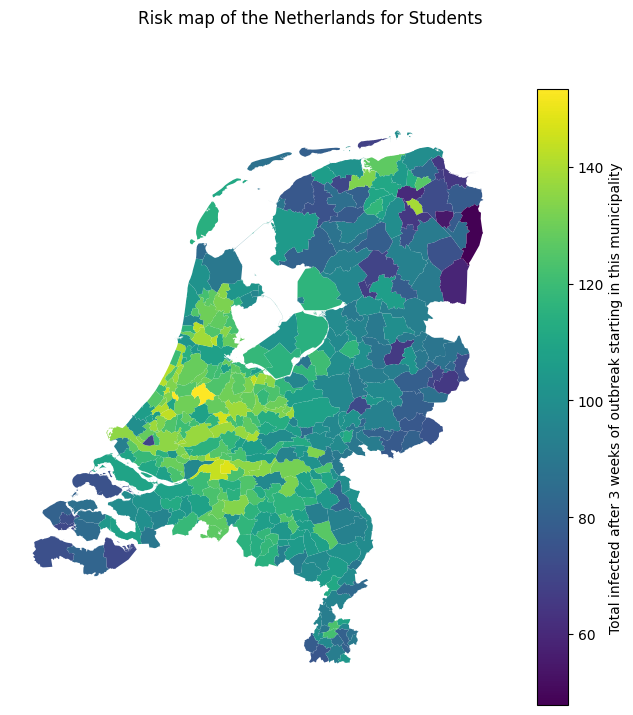

In [15]:
infected_per_municipality = np.load(os.getcwd() + '/cluster/results/3/High/Infected_Per_Municipality_New.npy')
#infected_per_municipality = risk_map
n_municipalities = infected_per_municipality.shape[0]
risk_data = np.zeros(n_municipalities)
for i in range(n_municipalities):
    risk_data[i] = np.sum(infected_per_municipality[i, t_max-1])

for loc in np.argsort(risk_data)[::-1]:
    print(str(loc) + '\t' + loc_name[loc] + ': ' + str(risk_data[loc]))


create_spatial_plot(risk_data, 'Risk map of the Netherlands for Students', 'Total infected after 3 weeks of outbreak starting in this municipality')

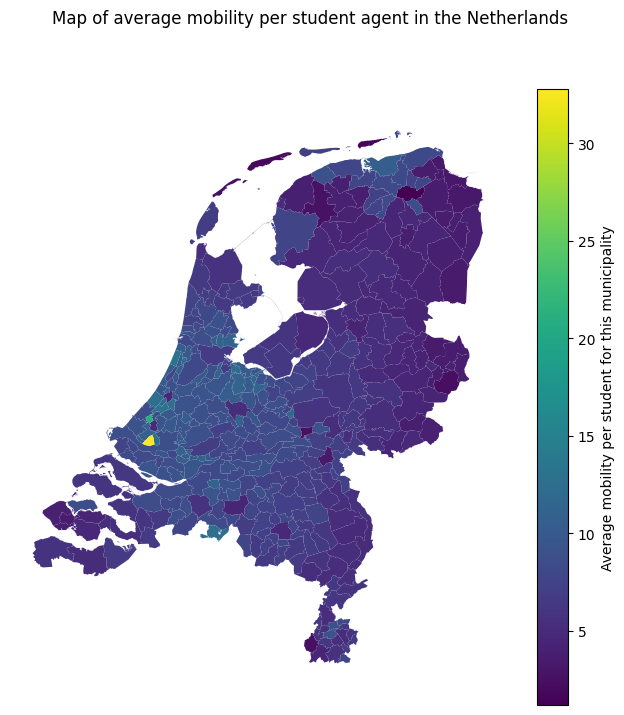

In [17]:
df_mobmat_freq = pd.read_csv('Data/Mob_grav_freq.csv', delimiter=',')
mobmat_freq = df_mobmat_freq[df_mobmat_freq.columns[1:]].to_numpy()

mobility_map = np.zeros(380)
for loc in range(380):
    demo_pop = np.maximum(DemoMat[loc, 3], 1)
    mobility_map[loc] = np.nansum(mobmat_freq[loc]) / demo_pop

#for loc in np.argsort(mobility_map)[::-1]:
#    print(str(loc) + '\t' + loc_name[loc] + ': ' + str(mobility_map[loc]))

create_spatial_plot(mobility_map, 'Map of average mobility per student agent in the Netherlands', 'Average mobility per student for this municipality')

260


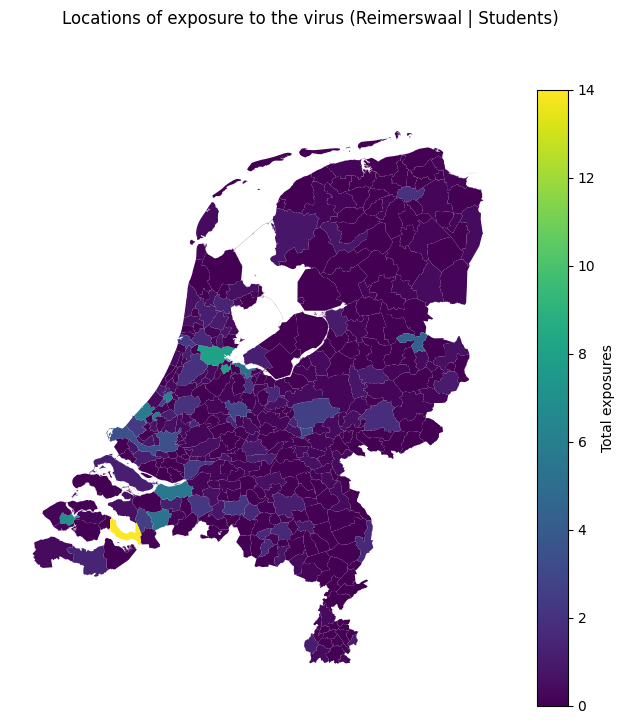

In [28]:
import numpy as np
import pandas as pd
import os

def load_infection_location(path_data, loc, group, run):
    # Load general model data
    peopleDF = pd.read_pickle(path_data + 'PeopleDF.pkl')
    extraPeopleDF = pd.read_pickle(path_data + 'ExtraPeopleDF.pkl')

    positions = np.load(path_data + 'Positions.npy')
    extraPositions = np.load(path_data + 'ExtraPositions.npy')

    status = np.load(path_data + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Status_' + str(run) + '.npz')
    uniLocs = np.array(pd.read_pickle(os.path.normpath(path_data + '../../../Gemeenten.pkl'))).T[0]
    uniGroups = np.unique(np.array(extraPeopleDF.Group))

    extra_agents = extraPeopleDF.loc[(extraPeopleDF['Home'] == uniLocs[loc]) & (extraPeopleDF['Group'] == uniGroups[group])]
    extra_pos = extraPositions[:, :, extra_agents.index]

    peopleDF = pd.concat([peopleDF, extra_agents], ignore_index=True)
    positions = np.append(positions, extra_pos, axis=2)

    # Load model output data
    timesteps = status['indptr'].shape[0] - 1
    data = status['data']
    indptr = status['indptr']
    indices = status['indices']

    # Compute for every timestep how many infected people there are in every municipality
    prev_exposed = set()
    infected_per_municipality = np.zeros((timesteps, 380))
    for t in range(0, timesteps):
        infected_per_municipality[t] = infected_per_municipality[t - 1]
        data_t = data[indptr[t] : indptr[t + 1]]
        agents_status_t = indices[indptr[t] : indptr[t + 1]]

        exposed_agents = agents_status_t[(data_t == 1)]
        new_exposed = set(exposed_agents).difference(prev_exposed)
        prev_exposed = exposed_agents

        day = np.mod(int(np.floor(t/24)), 7)
        hour = np.mod(t, 24)
        positions_of_exposure = positions[day, hour, np.array(list(new_exposed), dtype=int)].astype(int)
        infected_per_municipality[t, positions_of_exposure] += 1

    return infected_per_municipality

path = os.getcwd() + '/cluster/results/3/High/'

t_max = 21 * 24 
infect_map = np.zeros((380,380))
# emmen: 100
# 167 kerkrade
# 287 smallingerland
# 260 Reimerswaal
# 358 Winterswijk

for loc in [260]:
    print(loc)
    seed_data = []
    for seed in range(5):
        for run in range(5):
            data = load_infection_location(path + f'Seed_{seed}/', loc, 3, run)
        seed_data.append(data[t_max - 1])
    infect_map[loc] = combine_runs_avg(seed_data, 0)

#np.save(path + 'Exposure_Locations', infect_map)   


full_map = np.zeros(380)
for loc in range(380):
    full_map += infect_map[loc]

create_spatial_plot(full_map, 'Locations of exposure to the virus (Reimerswaal | Students)', 'Total exposures', 0, 14)

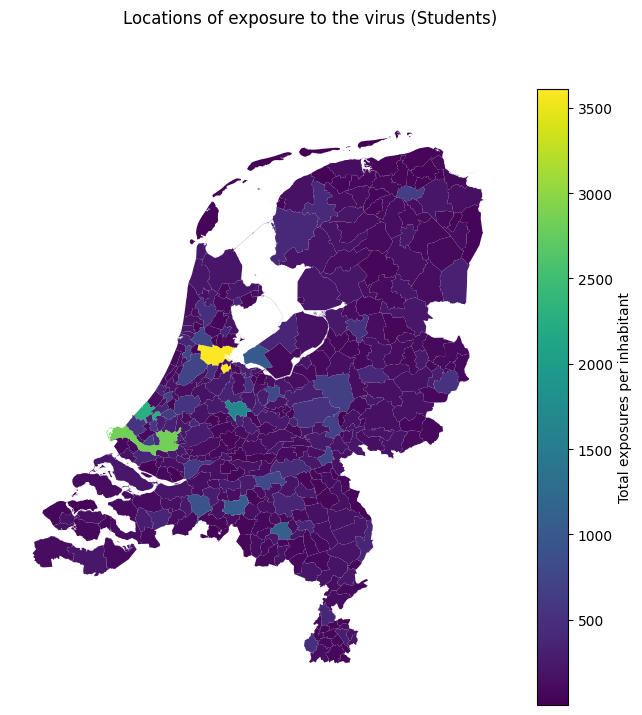

In [4]:
path = os.getcwd() + '/cluster/results/3/High/'

exposure_map = np.load(path + 'Exposure_Locations.npy')

final_exposure = np.zeros(380)
for loc in range(380):
    final_exposure += exposure_map[loc]

#for loc in range(380):
#    final_exposure[loc] = final_exposure[loc]

create_spatial_plot(final_exposure, 'Locations of exposure to the virus (Students)', 'Total exposures per inhabitant')

0	's-Gravenhage:  863.0101237189891
1	's-Hertogenbosch:  690.758990550175
2	Aa en Hunze:  740.850042030804
3	Aalburg:  659.4129241243515
4	Aalsmeer:  669.177434884097
5	Aalten:  700.6478492479195
6	Achtkarspelen:  371.3611262886623
7	Alblasserdam:  825.4545501987238
8	Albrandswaard:  1183.6784287701385
9	Alkmaar:  797.3622180850141
10	Almelo:  607.3905920937821
11	Almere:  690.1477225521398
12	Alphen aan den Rijn:  690.4970157125264
13	Alphen-Chaam:  1013.3342476632209
14	Ameland:  441.89248763614376
15	Amersfoort:  948.2508539076138
16	Amstelveen:  643.0789809502019
17	Amsterdam:  892.9520432065368
18	Apeldoorn:  708.8557077277417
19	Appingedam:  462.0636594139331
20	Arnhem:  633.1533826139199
21	Assen:  940.9573458920354
22	Asten:  862.8932349727563
23	Baarle-Nassau:  795.7546459140156
24	Baarn:  1288.4391519484516
25	Barendrecht:  1039.789197469465
26	Barneveld:  874.6246451886543
27	Bedum:  675.4157678416897
28	Beek:  582.5775631565157
29	Beemster:  712.8360566441335
30	Beesel:  71

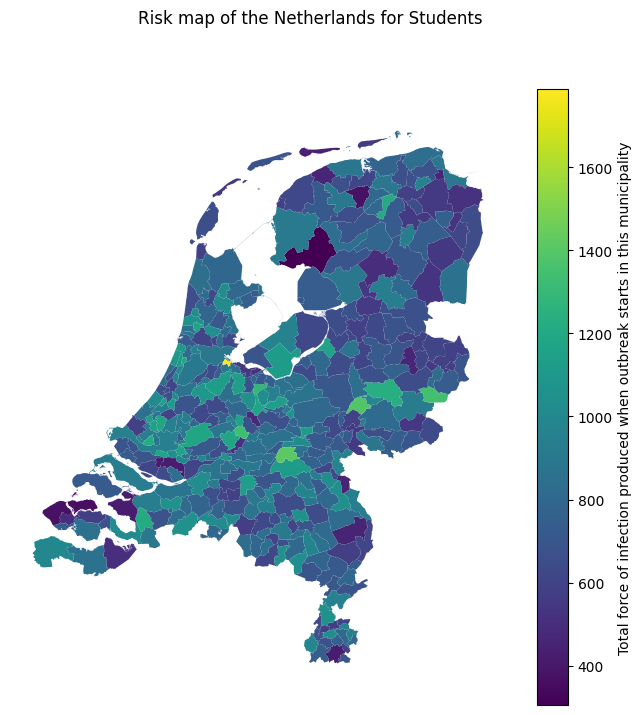

In [7]:
import os
import numpy as np
import pandas as pd

def load_foi_avg_runs(path_data, loc, group, seeds, runs):
    all_data = []
    for seed in range(seeds):
        path = path_data + f'Seed_{seed}/'
        for run in range(runs):
            foi_data = np.load(path + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Infection_Pressure_' + str(run) + '.npy')
            all_data.append(foi_data)

    # Average the data
    n_data = seeds * runs
    merged_data = np.zeros(all_data[0].shape)
    for i in range(n_data):
        merged_data = merged_data + all_data[i]
    merged_data = merged_data / n_data
    return merged_data

path = os.getcwd() + '/cluster/results/1/High/'

loc_name = np.array(pd.read_pickle(os.path.normpath(path + '../../Gemeenten.pkl'))).T[0]

risk_map = np.zeros(380)
for loc in range(380):
    infected_per_municipality = load_foi_avg_runs(path, loc, 1, 5, 5)
    t_max = infected_per_municipality.shape[0]
    risk = np.sum(infected_per_municipality[t_max - 1])
    risk_map[loc] = risk
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk))

create_spatial_plot(risk_map, 'Risk map of the Netherlands for Students', 'Total force of infection produced when outbreak starts in this municipality')

0	's-Gravenhage:  26.519999999999996
1	's-Hertogenbosch:  21.400000000000002
2	Aa en Hunze:  23.72
3	Aalburg:  19.76
4	Aalsmeer:  20.76
5	Aalten:  24.08
6	Achtkarspelen:  14.08
7	Alblasserdam:  25.64
8	Albrandswaard:  33.92
9	Alkmaar:  25.240000000000002
10	Almelo:  19.76
11	Almere:  22.6
12	Alphen aan den Rijn:  21.239999999999995
13	Alphen-Chaam:  28.880000000000003
14	Ameland:  16.68
15	Amersfoort:  29.08
16	Amstelveen:  21.360000000000003
17	Amsterdam:  27.279999999999998
18	Apeldoorn:  21.239999999999995
19	Appingedam:  16.0
20	Arnhem:  20.919999999999998
21	Assen:  27.2
22	Asten:  26.240000000000002
23	Baarle-Nassau:  22.88
24	Baarn:  38.0
25	Barendrecht:  30.4
26	Barneveld:  26.28
27	Bedum:  20.4
28	Beek:  19.52
29	Beemster:  23.36
30	Beesel:  21.240000000000002
31	Berg en Dal:  28.759999999999998
32	Bergeijk:  20.32
33	Bergen (L.):  27.32
34	Bergen (NH.):  20.400000000000002
35	Bergen op Zoom:  35.6
36	Berkelland:  28.32
37	Bernheze:  25.88
38	Best:  22.560000000000002
39	Beuni

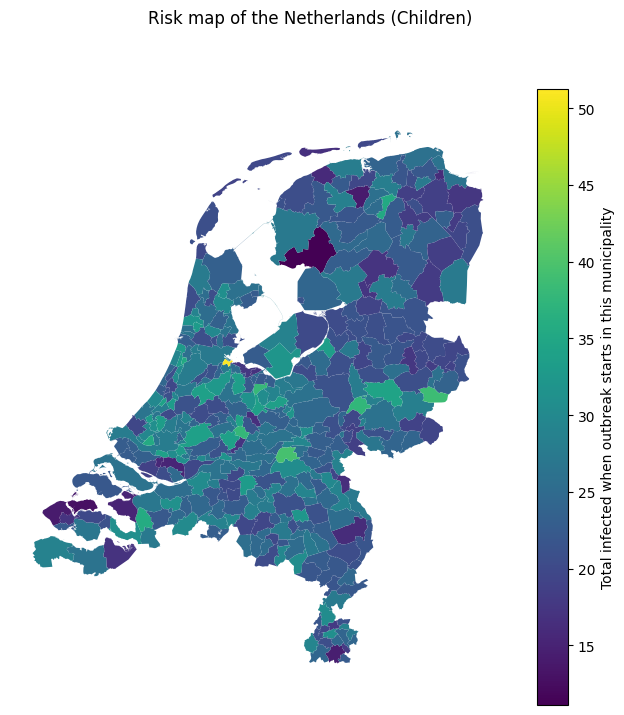

In [8]:
path = os.getcwd() + '/cluster/results/1/High/'

loc_name = np.array(pd.read_pickle(os.path.normpath(path + '../../Gemeenten.pkl'))).T[0]
n_mun = len(loc_name)
t_max = 21 * 24

risk_map = np.zeros(n_mun)
infected_per_municipality = np.zeros((n_mun, t_max, n_mun))
for loc in range(n_mun):
    infected_per_municipality[loc] = load_total_infected_avg_runs(path, loc, 1, 5, 5)
    risk_map[loc] = np.sum(infected_per_municipality[loc, t_max - 1])
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk_map[loc]))

# Store the infected data per municipality, because it takes a while to generate
np.save(path + 'Infected_Per_Municipality_1', infected_per_municipality)

create_spatial_plot(risk_map, 'Risk map of the Netherlands (Children)', 'Total infected when outbreak starts in this municipality')



In [11]:
infected_per_municipality = np.load(os.getcwd() + '/cluster/results/1/High/Infected_Per_Municipality_1.npy')
#infected_per_municipality = risk_map
n_municipalities = infected_per_municipality.shape[0]
risk_data = np.zeros(n_municipalities)
for i in range(n_municipalities):
    risk_data[i] = np.sum(infected_per_municipality[i, t_max-1])

for loc in np.argsort(risk_data)[::-1]:
    print(str(loc) + '\t' + loc_name[loc] + ': ' + str(risk_data[loc]))

NameError: name 't_max' is not defined

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

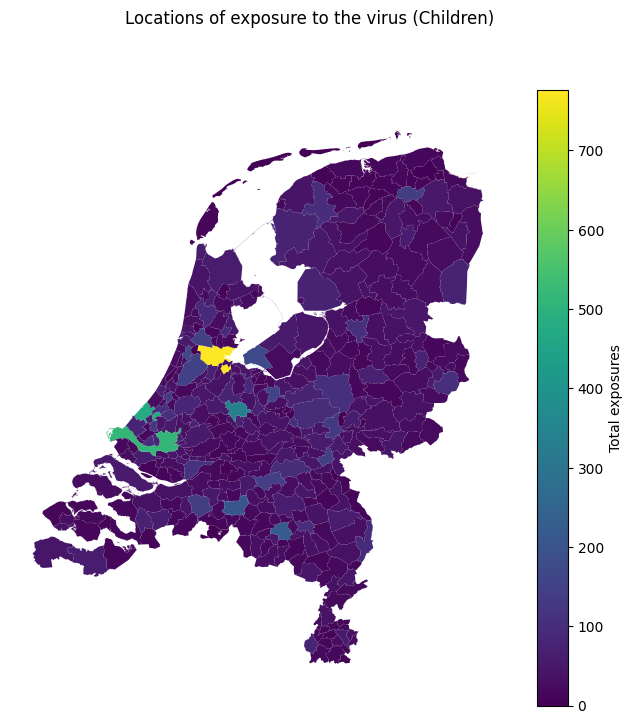

In [9]:
import numpy as np
import pandas as pd
import os

def load_infection_location(path_data, loc, group, run):
    # Load general model data
    peopleDF = pd.read_pickle(path_data + 'PeopleDF.pkl')
    extraPeopleDF = pd.read_pickle(path_data + 'ExtraPeopleDF.pkl')

    positions = np.load(path_data + 'Positions.npy')
    extraPositions = np.load(path_data + 'ExtraPositions.npy')

    status = np.load(path_data + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Status_' + str(run) + '.npz')
    uniLocs = np.array(pd.read_pickle(os.path.normpath(path_data + '../../../Gemeenten.pkl'))).T[0]
    uniGroups = np.unique(np.array(extraPeopleDF.Group))

    extra_agents = extraPeopleDF.loc[(extraPeopleDF['Home'] == uniLocs[loc]) & (extraPeopleDF['Group'] == uniGroups[group])]
    extra_pos = extraPositions[:, :, extra_agents.index]

    peopleDF = pd.concat([peopleDF, extra_agents], ignore_index=True)
    positions = np.append(positions, extra_pos, axis=2)

    # Load model output data
    timesteps = status['indptr'].shape[0] - 1
    data = status['data']
    indptr = status['indptr']
    indices = status['indices']

    # Compute for every timestep how many infected people there are in every municipality
    prev_exposed = set()
    infected_per_municipality = np.zeros((timesteps, 380))
    for t in range(0, timesteps):
        infected_per_municipality[t] = infected_per_municipality[t - 1]
        data_t = data[indptr[t] : indptr[t + 1]]
        agents_status_t = indices[indptr[t] : indptr[t + 1]]

        exposed_agents = agents_status_t[(data_t == 1)]
        new_exposed = set(exposed_agents).difference(prev_exposed)
        prev_exposed = exposed_agents

        day = np.mod(int(np.floor(t/24)), 7)
        hour = np.mod(t, 24)
        positions_of_exposure = positions[day, hour, np.array(list(new_exposed), dtype=int)].astype(int)
        infected_per_municipality[t, positions_of_exposure] += 1

    return infected_per_municipality

path = os.getcwd() + '/cluster/results/1/High/'

t_max = 21 * 24 
infect_map = np.zeros((380,380))
for loc in range(0,380):
    print(loc)
    seed_data = []
    for seed in range(5):
        for run in range(5):
            data = load_infection_location(path + f'Seed_{seed}/', loc, 1, run)
        seed_data.append(data[t_max - 1])
    infect_map[loc] = combine_runs_avg(seed_data, 0)

np.save(path + 'Exposure_Locations_1', infect_map)   


full_map = np.zeros(380)
for loc in range(380):
    full_map += infect_map[loc]

create_spatial_plot(full_map, 'Locations of exposure to the virus (Children)', 'Total exposures')

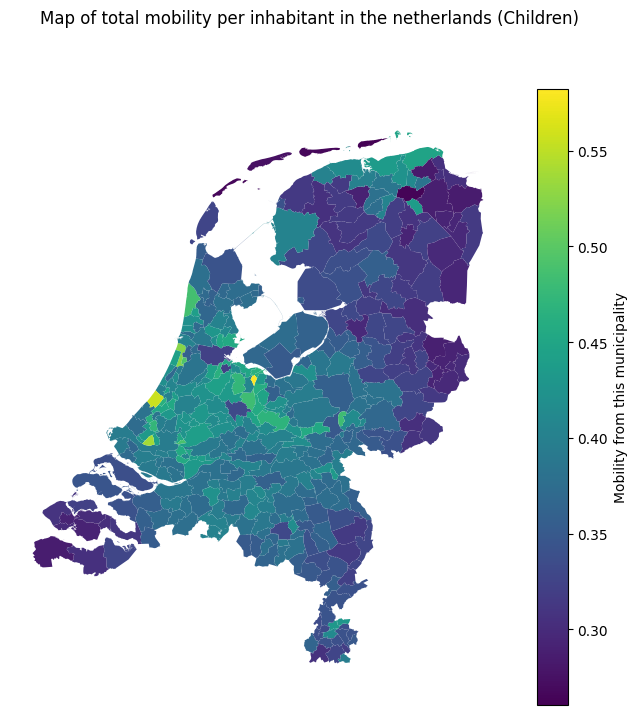

In [4]:
df_mobmat_inc = pd.read_csv('Data/Mob_grav_inc.csv', delimiter=',')
mobmat_inc = df_mobmat_inc[df_mobmat_inc.columns[1:]].to_numpy()

mobility_map = np.zeros(380)
for loc in range(380):
    demo_pop = np.maximum(DemoMat[loc, 5], 1)
    mobility_map[loc] = np.nansum(mobmat_inc[loc]) / demo_pop

#for loc in np.argsort(mobility_map)[::-1]:
#    print(str(loc) + '\t' + loc_name[loc] + ': ' + str(mobility_map[loc]))

create_spatial_plot(mobility_map, 'Map of total mobility per inhabitant in the netherlands (Children)', 'Mobility from this municipality')

0	's-Gravenhage:  3970.563076153302
1	's-Hertogenbosch:  3471.2618115839678
2	Aa en Hunze:  2709.1315116324968
3	Aalburg:  3691.4660583257364
4	Aalsmeer:  5146.481224284841
5	Aalten:  3367.7538764701308
6	Achtkarspelen:  2458.023751258704
7	Alblasserdam:  4807.321964773991
8	Albrandswaard:  3614.476748308852
9	Alkmaar:  3506.421533972256
10	Almelo:  3179.8994899996214
11	Almere:  4471.523366053934
12	Alphen aan den Rijn:  4382.431092074255
13	Alphen-Chaam:  4397.091837382635
14	Ameland:  3070.9816185016166
15	Amersfoort:  4001.2691889942125
16	Amstelveen:  3863.978987755432
17	Amsterdam:  4030.880816650433
18	Apeldoorn:  3304.2990843774887
19	Appingedam:  2495.6446863979036
20	Arnhem:  3598.559931405533
21	Assen:  3388.712882476656
22	Asten:  3423.1983964314254
23	Baarle-Nassau:  3624.290680105832
24	Baarn:  4672.456647502375
25	Barendrecht:  4229.965762177809
26	Barneveld:  3576.779542361711
27	Bedum:  3717.441326328274
28	Beek:  2965.230300595038
29	Beemster:  3933.8088288955973
30	B

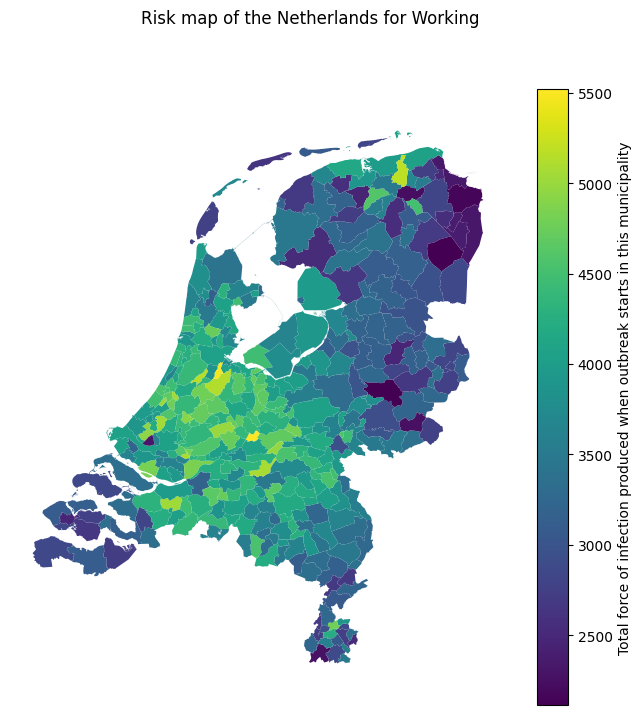

In [13]:
import os
import numpy as np
import pandas as pd

def load_foi_avg_runs(path_data, loc, group, seeds, runs):
    all_data = []
    for seed in range(seeds):
        path = path_data + f'Seed_{seed}/'
        for run in range(runs):
            foi_data = np.load(path + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Infection_Pressure_' + str(run) + '.npy')
            all_data.append(foi_data)

    # Average the data
    n_data = seeds * runs
    merged_data = np.zeros(all_data[0].shape)
    for i in range(n_data):
        merged_data = merged_data + all_data[i]
    merged_data = merged_data / n_data
    return merged_data

path = os.getcwd() + '/cluster/results/5/High/'

loc_name = np.array(pd.read_pickle(os.path.normpath(path + '../../Gemeenten.pkl'))).T[0]

risk_map = np.zeros(380)
for loc in range(380):
    infected_per_municipality = load_foi_avg_runs(path, loc, 5, 5, 5)
    t_max = infected_per_municipality.shape[0]
    risk = np.sum(infected_per_municipality[t_max - 1])
    risk_map[loc] = risk
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk))

create_spatial_plot(risk_map, 'Risk map of the Netherlands for Working', 'Total force of infection produced when outbreak starts in this municipality')

0	's-Gravenhage:  110.36000000000001
1	's-Hertogenbosch:  97.03999999999999
2	Aa en Hunze:  76.32
3	Aalburg:  103.8
4	Aalsmeer:  138.48
5	Aalten:  93.72
6	Achtkarspelen:  67.04
7	Alblasserdam:  126.96000000000001
8	Albrandswaard:  98.16
9	Alkmaar:  97.88000000000001
10	Almelo:  89.16
11	Almere:  123.39999999999999
12	Alphen aan den Rijn:  119.28
13	Alphen-Chaam:  122.28
14	Ameland:  87.92000000000002
15	Amersfoort:  110.24000000000001
16	Amstelveen:  108.67999999999999
17	Amsterdam:  111.91999999999999
18	Apeldoorn:  90.47999999999999
19	Appingedam:  68.4
20	Arnhem:  95.12
21	Assen:  94.24000000000001
22	Asten:  93.28
23	Baarle-Nassau:  100.24
24	Baarn:  130.64000000000001
25	Barendrecht:  114.4
26	Barneveld:  102.52
27	Bedum:  102.72
28	Beek:  81.44
29	Beemster:  108.44
30	Beesel:  93.04
31	Berg en Dal:  108.04
32	Bergeijk:  112.80000000000001
33	Bergen (L.):  99.68
34	Bergen (NH.):  101.28
35	Bergen op Zoom:  81.52000000000001
36	Berkelland:  88.64
37	Bernheze:  119.12000000000002
38

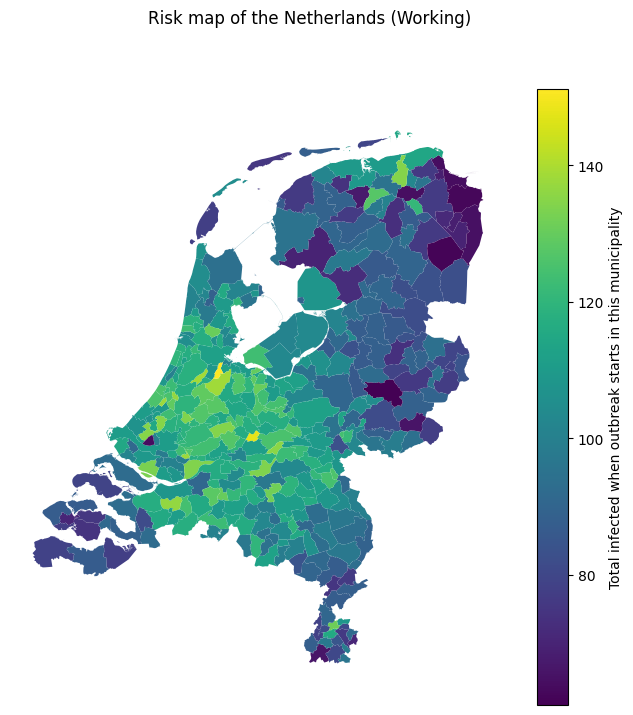

In [16]:
path = os.getcwd() + '/cluster/results/5/High/'

loc_name = np.array(pd.read_pickle(os.path.normpath(path + '../../Gemeenten.pkl'))).T[0]
n_mun = len(loc_name)
t_max = 21 * 24

risk_map = np.zeros(n_mun)
infected_per_municipality = np.zeros((n_mun, t_max, n_mun))
for loc in range(n_mun):
    infected_per_municipality[loc] = load_total_infected_avg_runs(path, loc, 5, 5, 5)
    risk_map[loc] = np.sum(infected_per_municipality[loc, t_max - 1])
    print(str(loc) +'\t' + loc_name[loc] + ':  ' + str(risk_map[loc]))

# Store the infected data per municipality, because it takes a while to generate
np.save(path + 'Infected_Per_Municipality_5', infected_per_municipality)

create_spatial_plot(risk_map, 'Risk map of the Netherlands (Working)', 'Total infected when outbreak starts in this municipality')



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

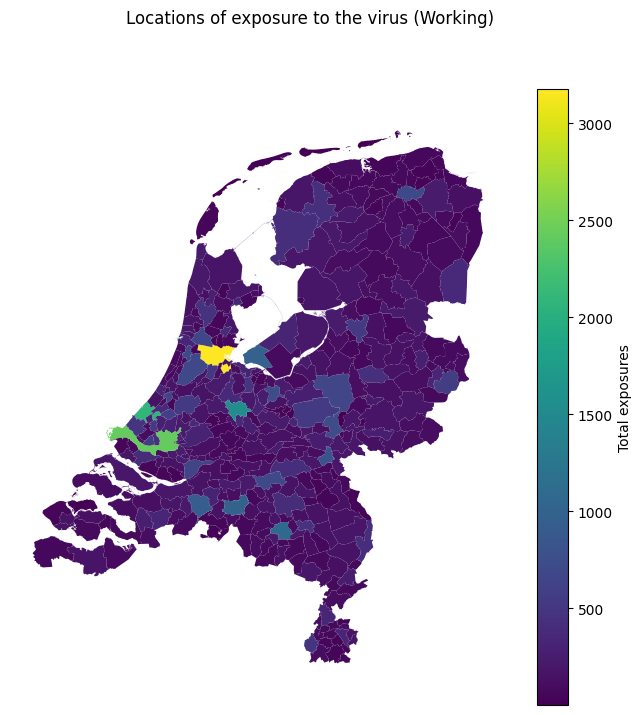

In [4]:
import numpy as np
import pandas as pd
import os

def load_infection_location(path_data, loc, group, run):
    # Load general model data
    peopleDF = pd.read_pickle(path_data + 'PeopleDF.pkl')
    extraPeopleDF = pd.read_pickle(path_data + 'ExtraPeopleDF.pkl')

    positions = np.load(path_data + 'Positions.npy')
    extraPositions = np.load(path_data + 'ExtraPositions.npy')

    status = np.load(path_data + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Status_' + str(run) + '.npz')
    uniLocs = np.array(pd.read_pickle(os.path.normpath(path_data + '../../../Gemeenten.pkl'))).T[0]
    uniGroups = np.unique(np.array(extraPeopleDF.Group))

    extra_agents = extraPeopleDF.loc[(extraPeopleDF['Home'] == uniLocs[loc]) & (extraPeopleDF['Group'] == uniGroups[group])]
    extra_pos = extraPositions[:, :, extra_agents.index]

    peopleDF = pd.concat([peopleDF, extra_agents], ignore_index=True)
    positions = np.append(positions, extra_pos, axis=2)

    # Load model output data
    timesteps = status['indptr'].shape[0] - 1
    data = status['data']
    indptr = status['indptr']
    indices = status['indices']

    # Compute for every timestep how many infected people there are in every municipality
    prev_exposed = set()
    infected_per_municipality = np.zeros((timesteps, 380))
    for t in range(0, timesteps):
        infected_per_municipality[t] = infected_per_municipality[t - 1]
        data_t = data[indptr[t] : indptr[t + 1]]
        agents_status_t = indices[indptr[t] : indptr[t + 1]]

        exposed_agents = agents_status_t[(data_t == 1)]
        new_exposed = set(exposed_agents).difference(prev_exposed)
        prev_exposed = exposed_agents

        day = np.mod(int(np.floor(t/24)), 7)
        hour = np.mod(t, 24)
        positions_of_exposure = positions[day, hour, np.array(list(new_exposed), dtype=int)].astype(int)
        infected_per_municipality[t, positions_of_exposure] += 1

    return infected_per_municipality

path = os.getcwd() + '/cluster/results/5/High/'

t_max = 21 * 24 
infect_map = np.zeros((380,380))
for loc in range(0,380):
    print(loc)
    seed_data = []
    for seed in range(5):
        for run in range(5):
            data = load_infection_location(path + f'Seed_{seed}/', loc, 5, run)
        seed_data.append(data[t_max - 1])
    infect_map[loc] = combine_runs_avg(seed_data, 0)

np.save(path + 'Exposure_Locations_5', infect_map)   


full_map = np.zeros(380)
for loc in range(380):
    full_map += infect_map[loc]

create_spatial_plot(full_map, 'Locations of exposure to the virus (Working)', 'Total exposures')

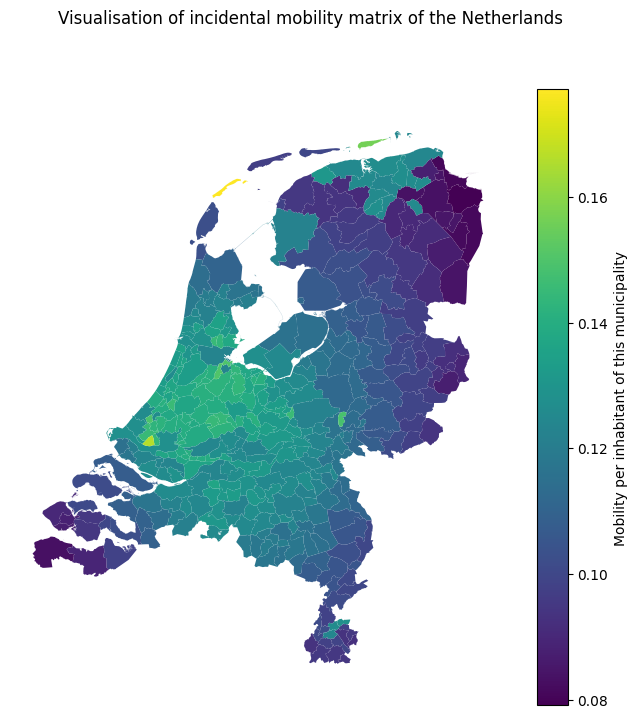

In [9]:
df_mobmat_inc = pd.read_csv('Data/Mob_grav_inc.csv', delimiter=',')
mobmat_inc = df_mobmat_inc[df_mobmat_inc.columns[1:]].to_numpy()

mobility_map = np.zeros(380)
for loc in range(380):
    demo_pop = np.sum(DemoMat[loc])
    mobility_map[loc] = np.nansum(mobmat_inc[loc]) / demo_pop

create_spatial_plot(mobility_map, 'Visualisation of incidental mobility matrix of the Netherlands', 'Mobility per inhabitant of this municipality')

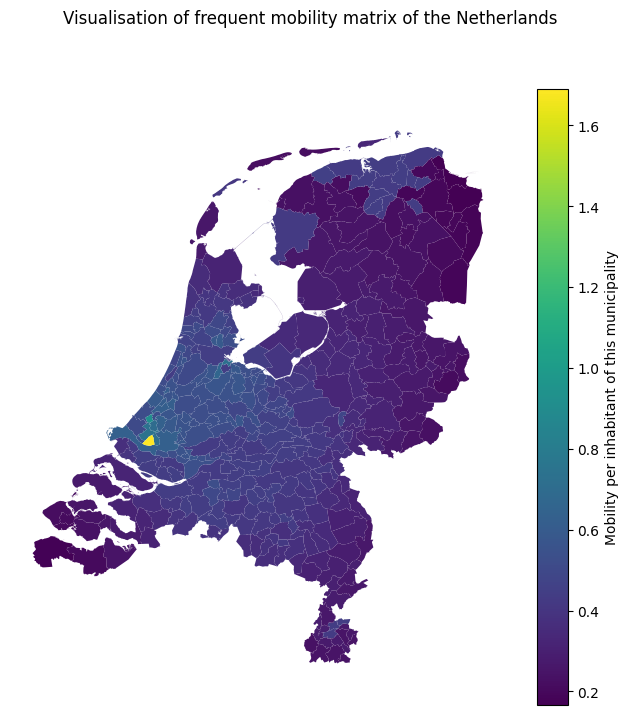

In [10]:
df_mobmat_freq = pd.read_csv('Data/Mob_grav_freq.csv', delimiter=',')
mobmat_freq = df_mobmat_freq[df_mobmat_freq.columns[1:]].to_numpy()

mobility_map = np.zeros(380)
for loc in range(380):
    demo_pop = np.sum(DemoMat[loc])
    mobility_map[loc] = np.nansum(mobmat_freq[loc]) / demo_pop

create_spatial_plot(mobility_map, 'Visualisation of frequent mobility matrix of the Netherlands', 'Mobility per inhabitant of this municipality')

250	Ouder-Amstel: 151.16000000000003
66	Culemborg: 147.36
4	Aalsmeer: 138.48
72	De Ronde Venen: 138.32
333	Voorschoten: 138.0
147	Hendrik-Ido-Ambacht: 137.92000000000002
129	Halderberge: 136.68
184	Leiderdorp: 136.36
306	Tiel: 135.51999999999998
256	Pijnacker-Nootdorp: 134.92000000000002
207	Midden-Delfland: 134.72
357	Winsum: 134.52
194	Lopik: 134.28000000000003
85	Dordrecht: 134.2
339	Waddinxveen: 134.16000000000003
197	Maasdriel: 133.84000000000003
170	Korendijk: 132.96
283	Sint-Michielsgestel: 131.76
279	Schinnen: 131.12
24	Baarn: 130.64000000000001
361	Wormerland: 130.52
83	Dongen: 130.2
160	Huizen: 129.60000000000002
372	Zoeterwoude: 129.28
220	Nieuwkoop: 129.0
179	Laren: 128.84000000000003
242	Oosterhout: 128.12
360	Woerden: 127.76000000000002
122	Grootegast: 127.32
367	Zederik: 127.12
7	Alblasserdam: 126.96000000000001
265	Rhenen: 126.80000000000001
45	Bodegraven-Reeuwijk: 126.48
355	Wijdemeren: 126.4
369	Zeist: 125.88
362	Woudenberg: 125.80000000000001
215	Mook en Middelaar: 1

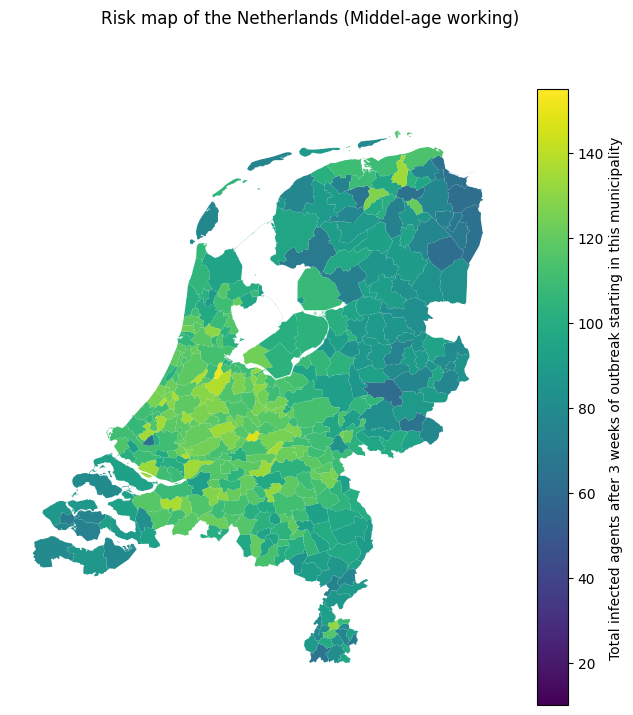

In [46]:
demo = 5

loc_name = np.array(pd.read_pickle(os.path.normpath('cluster/results/Gemeenten.pkl'))).T[0]

infected_per_municipality = np.load(os.getcwd() + f'/cluster/results/{demo}/High/Infected_Per_Municipality_{demo}.npy')
#infected_per_municipality = risk_map
n_municipalities = infected_per_municipality.shape[0]
t_max = infected_per_municipality.shape[1]
risk_data = np.zeros(n_municipalities)
for i in range(n_municipalities):
    risk_data[i] = np.sum(infected_per_municipality[i, t_max-1])

for loc in np.argsort(risk_data)[::-1]:
    print(str(loc) + '\t' + loc_name[loc] + ': ' + str(risk_data[loc]))


create_spatial_plot(risk_data, 'Risk map of the Netherlands (Middel-age working)', 'Total infected agents after 3 weeks of outbreak starting in this municipality', 10, 155)

2.0
3177.4


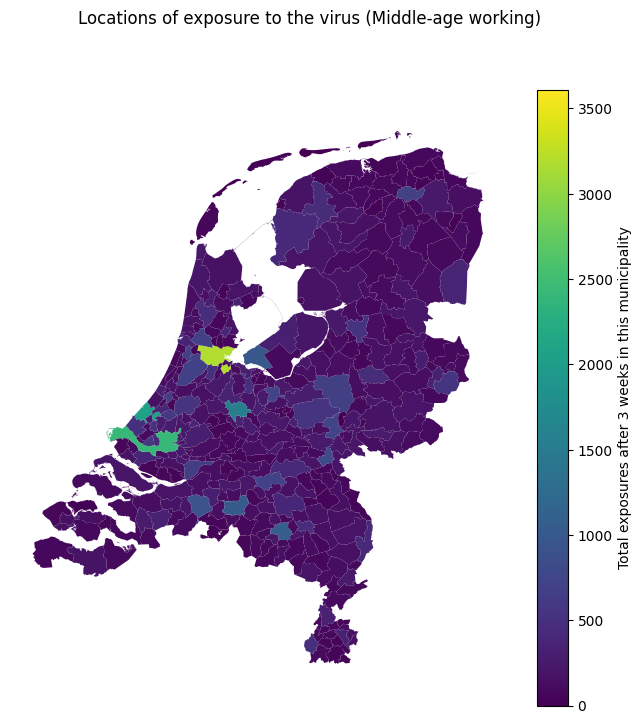

In [41]:
demo = 5

path = os.getcwd() + f'/cluster/results/{demo}/High/'

exposure_map = np.load(path + f'Exposure_Locations_{demo}.npy')

final_exposure = np.zeros(380)
for loc in range(380):
    final_exposure += exposure_map[loc]

print(np.min(final_exposure))
print(np.max(final_exposure))

create_spatial_plot(final_exposure, 'Locations of exposure to the virus (Middle-age working)', 'Total exposures after 3 weeks in this municipality', 0, 3610)

1.6604796572258138
4010.8089908854818


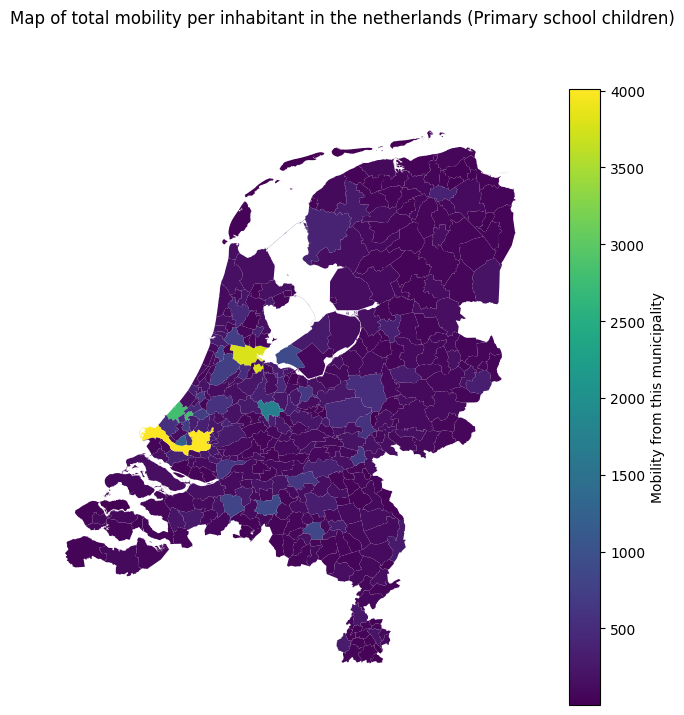

In [49]:
demo = 5

# df_mobmat_inc = pd.read_csv('Data/Mob_grav_inc.csv', delimiter=',')
# mobmat_inc = df_mobmat_inc[df_mobmat_inc.columns[1:]].to_numpy()

# mobility_map = np.zeros(380)
# for loc in range(380):
#     demo_pop = np.maximum(DemoMat[loc, demo], 1)
#     mobility_map[loc] = np.nansum(mobmat_inc[loc]) / demo_pop

df_mobmat_freq = pd.read_csv('Data/Mob_grav_freq.csv', delimiter=',')
mobmat_freq = df_mobmat_freq[df_mobmat_freq.columns[1:]].to_numpy()

mobility_map = np.zeros(380)
for loc in range(380):
    demo_pop = np.maximum(DemoMat[loc, demo], 1)
    mobility_map[loc] = np.nansum(mobmat_freq[loc])

print(np.min(mobility_map))
print(np.max(mobility_map))

create_spatial_plot(mobility_map, 'Map of total mobility per inhabitant in the netherlands (Primary school children)', 'Mobility from this municipality')